# MlFlow Experiment Tracking Setup

In [1]:
import mlflow
mlflow.autolog()
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("ResNet50_Unfreeze")
mlflow.set_tag("mlflow.runName", "RestNet50_Unfreeze_version_1")
mlflow.set_experiment_tag

<function mlflow.tracking.fluent.set_experiment_tag(key: str, value: Any) -> None>

# Imports

In [2]:
import os
import cv2
import sys
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
#Using Resnet50 for classification
import torchvision.models as models
import torch.nn as nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
import numpy as np

MAIN_DIR = Path("__file__").resolve().parent.parent.parent
CLASSIFICATION_MAPPING_DIR = os.path.join(MAIN_DIR, "classification_mapping") 
if CLASSIFICATION_MAPPING_DIR not in sys.path:
    sys.path.insert(0, CLASSIFICATION_MAPPING_DIR)
from classification_mapping import CLASSIFICATION_MAPPING

DATA_DIR = os.path.join(MAIN_DIR, 'data')
TRANSLATED_DATA_DIR = os.path.join(MAIN_DIR, 'data_translated_ResNet50')

2025/06/25 15:23:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [3]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# Loading Dataset

In [4]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [5]:
# Function to transform images to 224x224 for ResNet with normalization based on
# original model image normalization settings
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [6]:
def transformed_image(image_path:str) -> torch.tensor:
    image = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    image_tensor = transform(img_pil)
    return image_tensor

In [7]:
data, labels = [], []

# Reconverting the image to view in data_translated
mean = torch.tensor(mean).view(3, 1, 1)
std = torch.tensor(std).view(3, 1, 1)

for dir_ in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, dir_)
    translated_path = os.path.join(TRANSLATED_DATA_DIR, dir_)
    if not os.path.exists(translated_path): os.makedirs(translated_path)

    for img in os.listdir(path):
        # Load and transform the image
        image_tensor = transformed_image(os.path.join(path, img))
        data.append(image_tensor)
        labels.append(dir_)

        # Convert back to PIL image, unnormalize, and save
        unnormalized = image_tensor * std + mean
        unnormalized = unnormalized.clamp(0, 1)
        
        image_pil = to_pil_image(unnormalized)
        image_translated_path = os.path.join(translated_path, img)
        image_pil.save(image_translated_path)

In [8]:
print(len(data))

178


In [9]:
class SignDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.tensor([CLASSIFICATION_MAPPING[label] for label in labels], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    @property
    def classes(self):
        return self.data.classes

In [10]:
dataset = SignDataset(data, labels)
len(dataset)

178

In [11]:
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
print(len(train_dataset))
print(len(test_dataset))

143
35


In [12]:
train_dataloader = DataLoader(dataset, batch_size = 16, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle = True)

In [13]:
for data, label in train_dataloader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([16, 3, 224, 224])
torch.Size([16])


# Loading Pre-trained Model from Pytorch

In [14]:
def create_model():
    # Load ResNet50 with pretrained weights
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    num_classes = 4

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = True

    # Replace the final fully connected layer (model.fc)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Unfreeze only the new fc layer
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

In [15]:
model = create_model()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# Add checkpoint to model
from torch.utils.checkpoint import checkpoint_sequential
class ResNet50Checkpointed(nn.Module):
    # watch out if segment size is greater than the smaller layers inside a layer => error
    def __init__(self, model, num_segments=4):  # You can tune this
        super().__init__()
        super().__init__()

        # Stem: conv1 → bn1 → relu → maxpool
        self.stem = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool
        )

        # Residual blocks (for checkpointing)
        self.blocks = nn.Sequential(
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        )

        self.num_segments = num_segments

        # Pooling and classification head
        self.avgpool = model.avgpool
        self.fc = model.fc  # Already modified with correct num_classes

    def forward(self, x):
        x = self.stem(x)
        x = checkpoint_sequential(self.blocks, self.num_segments, x, use_reentrant=False)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [17]:
model = ResNet50Checkpointed(model = create_model()).to(DEVICE)
model # won't say which part is checkpointed

ResNet50Checkpointed(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0)

# Model training

In [19]:
num_epochs = 100
train_losses, val_losses = [], []
train_accuracy, val_accuracy = [], [] 
train_accuracy_obj = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
validation_accuracy_obj = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)

In [20]:
for epoch in range(num_epochs):
    model.train() #setting model mode .train or .eval
    running_loss = 0.0
    train_accuracy_obj.reset()

    # its not acutally each image here but a batch of images instead (batch size = 16 so 16 images)
    for image_batch, label_batch in tqdm(train_dataloader, desc = "Training loop"):
        images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images) # logits output
        # logits output can work directly with labels
        loss = criterion(outputs, labels)
        # logits output can work directly with labels
        # Accuracy work by identifying the dimensions between outputs and labels
        # If same dimension -> labels to labels. If diff dimensions -> Logits to Labels
        train_accuracy_obj.update(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)
    train_acc = train_accuracy_obj.compute().item()
    train_accuracy.append(train_acc)

    #Validation phase
    model.eval()
    running_loss = 0.0
    validation_accuracy_obj.reset()
    with torch.no_grad():
        for image_batch, label_batch in tqdm(test_dataloader, desc = "Validation loop"):
            images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            validation_accuracy_obj.update(outputs, labels)
    val_loss = running_loss / len(test_dataloader.dataset)
    val_acc = validation_accuracy_obj.compute().item()
    val_losses.append(val_loss)
    val_accuracy.append(val_acc)
    

    print("Epoch %d out of %s - Train loss: %s , Validation loss: %s , Train accuracy: %s , Validation accuracy: %s " % (epoch + 1, 
                                                                                                                         num_epochs, 
                                                                                                                         train_loss, 
                                                                                                                         val_loss,
                                                                                                                         train_acc,
                                                                                                                         val_acc))

Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 out of 100 - Train loss: 1.3660374035995997 , Validation loss: 1.0279952764511109 , Train accuracy: 0.3228854835033417 , Validation accuracy: 0.8642857074737549 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 out of 100 - Train loss: 0.9273710009757052 , Validation loss: 0.6107683300971984 , Train accuracy: 0.8527125716209412 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 out of 100 - Train loss: 0.5200415936748634 , Validation loss: 0.21908953274999346 , Train accuracy: 0.9791666865348816 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 out of 100 - Train loss: 0.2443874069813932 , Validation loss: 0.06293877134365695 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 out of 100 - Train loss: 0.09580001368951262 , Validation loss: 0.03318098291222538 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 out of 100 - Train loss: 0.07215179988507474 , Validation loss: 0.025833483093551227 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 out of 100 - Train loss: 0.04520478434442134 , Validation loss: 0.023546159693173 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 out of 100 - Train loss: 0.052343589619974075 , Validation loss: 0.012433941782053029 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 out of 100 - Train loss: 0.05290301813838187 , Validation loss: 0.009901923626395208 , Train accuracy: 0.9885262250900269 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 out of 100 - Train loss: 0.028480733127406475 , Validation loss: 0.008827387155698878 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 out of 100 - Train loss: 0.02711806291442239 , Validation loss: 0.004669155858989272 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 out of 100 - Train loss: 0.05462173682250333 , Validation loss: 0.005199130784187998 , Train accuracy: 0.9904752969741821 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13 out of 100 - Train loss: 0.029145620344729905 , Validation loss: 0.004504269255059106 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 out of 100 - Train loss: 0.016716514326883165 , Validation loss: 0.006667129921593837 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15 out of 100 - Train loss: 0.01842144328389275 , Validation loss: 0.0036376790792149094 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16 out of 100 - Train loss: 0.019311018895064848 , Validation loss: 0.004993010046226638 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17 out of 100 - Train loss: 0.02597655914723873 , Validation loss: 0.003796821486737047 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18 out of 100 - Train loss: 0.015546013339516822 , Validation loss: 0.0009901229075954428 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19 out of 100 - Train loss: 0.019486375990208617 , Validation loss: 0.0033562633075884412 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20 out of 100 - Train loss: 0.053045546154627636 , Validation loss: 0.011261323160891021 , Train accuracy: 0.9836215972900391 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21 out of 100 - Train loss: 0.028502238788798952 , Validation loss: 0.0066167725449694055 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22 out of 100 - Train loss: 0.030161672679895765 , Validation loss: 0.012282644957304 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23 out of 100 - Train loss: 0.056622378946690075 , Validation loss: 0.012739798054099083 , Train accuracy: 0.9905660152435303 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24 out of 100 - Train loss: 0.06904365009303844 , Validation loss: 0.007884370206323052 , Train accuracy: 0.9864864945411682 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25 out of 100 - Train loss: 0.026135791344254203 , Validation loss: 0.004616313800215721 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26 out of 100 - Train loss: 0.012483079091049312 , Validation loss: 0.004396615713319209 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27 out of 100 - Train loss: 0.02422475456940324 , Validation loss: 0.004141388268076948 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28 out of 100 - Train loss: 0.015162137075421515 , Validation loss: 0.007243366709112057 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29 out of 100 - Train loss: 0.027176123447297664 , Validation loss: 0.004848928217376982 , Train accuracy: 0.9905660152435303 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30 out of 100 - Train loss: 0.023011603193838943 , Validation loss: 0.006906808937700199 , Train accuracy: 0.9904752969741821 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31 out of 100 - Train loss: 0.034424544196952594 , Validation loss: 0.0051007753903312344 , Train accuracy: 0.9884355664253235 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32 out of 100 - Train loss: 0.008526676847191338 , Validation loss: 0.003491488840830113 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33 out of 100 - Train loss: 0.025366398286116257 , Validation loss: 0.004098370634684605 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34 out of 100 - Train loss: 0.025137992785050627 , Validation loss: 0.007571729365736246 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35 out of 100 - Train loss: 0.013125593585663297 , Validation loss: 0.003596634145027825 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36 out of 100 - Train loss: 0.012256559392625696 , Validation loss: 0.004705151935507144 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37 out of 100 - Train loss: 0.00956179675635662 , Validation loss: 0.0052730285695620945 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38 out of 100 - Train loss: 0.005740652185226424 , Validation loss: 0.005087356777429315 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39 out of 100 - Train loss: 0.006521936704854617 , Validation loss: 0.003089754017336028 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40 out of 100 - Train loss: 0.006201557961575101 , Validation loss: 0.0048212456916059765 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41 out of 100 - Train loss: 0.003553290605503187 , Validation loss: 0.0022627296235961172 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42 out of 100 - Train loss: 0.021857658442988825 , Validation loss: 0.00200466918343279 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43 out of 100 - Train loss: 0.022193108842279135 , Validation loss: 0.004443227631937979 , Train accuracy: 0.9861111044883728 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44 out of 100 - Train loss: 0.015418809890914499 , Validation loss: 0.016166130338595913 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45 out of 100 - Train loss: 0.02597149983676297 , Validation loss: 0.011162229148404939 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46 out of 100 - Train loss: 0.008455729289922151 , Validation loss: 0.014671735570300371 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47 out of 100 - Train loss: 0.008580421045255126 , Validation loss: 0.012772600003518163 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48 out of 100 - Train loss: 0.005640841507760996 , Validation loss: 0.00755737337084221 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49 out of 100 - Train loss: 0.0056502832350938505 , Validation loss: 0.00817747905467903 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50 out of 100 - Train loss: 0.012988798179025396 , Validation loss: 0.008781056586719517 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51 out of 100 - Train loss: 0.01628458805989181 , Validation loss: 0.011461219577384846 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52 out of 100 - Train loss: 0.008345106423026724 , Validation loss: 0.028029523316113875 , Train accuracy: 1.0 , Validation accuracy: 0.9772727489471436 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53 out of 100 - Train loss: 0.008139738533122654 , Validation loss: 0.004275914717332593 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54 out of 100 - Train loss: 0.014871256917798788 , Validation loss: 0.009208691110169248 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55 out of 100 - Train loss: 0.008244843980862518 , Validation loss: 0.008799532062611044 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56 out of 100 - Train loss: 0.034254535823390726 , Validation loss: 0.008073061292192766 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57 out of 100 - Train loss: 0.005438938318343645 , Validation loss: 0.004965460806020668 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58 out of 100 - Train loss: 0.004399291815215282 , Validation loss: 0.00848755249088364 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59 out of 100 - Train loss: 0.0025983606936054284 , Validation loss: 0.004277475500046941 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60 out of 100 - Train loss: 0.013738155302204442 , Validation loss: 0.010961693656593394 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61 out of 100 - Train loss: 0.0015110105689447582 , Validation loss: 0.0034459096579147236 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62 out of 100 - Train loss: 0.004613739553462254 , Validation loss: 0.001952610514958256 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63 out of 100 - Train loss: 0.006009176111874286 , Validation loss: 0.006173917256611665 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64 out of 100 - Train loss: 0.02101604994438756 , Validation loss: 0.014175906611074294 , Train accuracy: 0.9905660152435303 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65 out of 100 - Train loss: 0.0049355723371917615 , Validation loss: 0.017136384689781282 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66 out of 100 - Train loss: 0.004294940641966094 , Validation loss: 0.0013670257970391374 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67 out of 100 - Train loss: 0.006357687747817528 , Validation loss: 0.0029407990521576723 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68 out of 100 - Train loss: 0.003339967755810096 , Validation loss: 0.0008451487220424627 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69 out of 100 - Train loss: 0.0017080875427535412 , Validation loss: 0.0009839864830220384 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70 out of 100 - Train loss: 0.0011046758677622074 , Validation loss: 0.00022047675031769488 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71 out of 100 - Train loss: 0.0014747308300326713 , Validation loss: 0.00020947896867125695 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72 out of 100 - Train loss: 0.0010211208332957847 , Validation loss: 0.0004457076169533788 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73 out of 100 - Train loss: 0.0012597113970688053 , Validation loss: 0.0007713286497164518 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74 out of 100 - Train loss: 0.012634998504621804 , Validation loss: 0.0011621134889927426 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75 out of 100 - Train loss: 0.014500589737815133 , Validation loss: 0.008571892178484372 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76 out of 100 - Train loss: 0.07244339403225465 , Validation loss: 0.021907068812288343 , Train accuracy: 0.9797297120094299 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77 out of 100 - Train loss: 0.06366044801942418 , Validation loss: 0.005642085144479227 , Train accuracy: 0.9862987995147705 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78 out of 100 - Train loss: 0.018866811219728396 , Validation loss: 0.0063588453456759455 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79 out of 100 - Train loss: 0.031927744575430836 , Validation loss: 0.01598626217538757 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80 out of 100 - Train loss: 0.03955303040448199 , Validation loss: 0.09690364521395947 , Train accuracy: 0.995192289352417 , Validation accuracy: 0.9564394354820251 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81 out of 100 - Train loss: 0.03090298075354501 , Validation loss: 0.06751458869922707 , Train accuracy: 0.995192289352417 , Validation accuracy: 0.9772727489471436 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82 out of 100 - Train loss: 0.019528093653615942 , Validation loss: 0.029911774050976548 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83 out of 100 - Train loss: 0.010702462202419391 , Validation loss: 0.03213398090062713 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84 out of 100 - Train loss: 0.006914912040209335 , Validation loss: 0.043050705535902775 , Train accuracy: 1.0 , Validation accuracy: 0.9772727489471436 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85 out of 100 - Train loss: 0.005890146101919118 , Validation loss: 0.04405323964379672 , Train accuracy: 1.0 , Validation accuracy: 0.9772727489471436 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86 out of 100 - Train loss: 0.0024816626499752316 , Validation loss: 0.022480364214009438 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87 out of 100 - Train loss: 0.003980898685502202 , Validation loss: 0.029495292383840674 , Train accuracy: 1.0 , Validation accuracy: 0.9772727489471436 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88 out of 100 - Train loss: 0.0019487809400293935 , Validation loss: 0.04973418033150665 , Train accuracy: 1.0 , Validation accuracy: 0.9772727489471436 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89 out of 100 - Train loss: 0.0040078683771988316 , Validation loss: 0.05007103288246851 , Train accuracy: 1.0 , Validation accuracy: 0.9772727489471436 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90 out of 100 - Train loss: 0.0476299071098479 , Validation loss: 0.009685292281210423 , Train accuracy: 0.9885262250900269 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91 out of 100 - Train loss: 0.011758460903937897 , Validation loss: 0.007565361344521599 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92 out of 100 - Train loss: 0.004371634464752808 , Validation loss: 0.012591271465810547 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93 out of 100 - Train loss: 0.012663042392539844 , Validation loss: 0.002965515067002603 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94 out of 100 - Train loss: 0.026538463319871534 , Validation loss: 0.008585355718553598 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95 out of 100 - Train loss: 0.023615608745244113 , Validation loss: 0.025599738210439683 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96 out of 100 - Train loss: 0.05225448168060753 , Validation loss: 0.02066234688141516 , Train accuracy: 0.9883385896682739 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97 out of 100 - Train loss: 0.029223024824194695 , Validation loss: 0.004804334363767079 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98 out of 100 - Train loss: 0.012560160736438264 , Validation loss: 0.004091440347422447 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99 out of 100 - Train loss: 0.01692351833864879 , Validation loss: 0.00260354243551514 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100 out of 100 - Train loss: 0.006386932948332155 , Validation loss: 0.0009200081428779023 , Train accuracy: 1.0 , Validation accuracy: 1.0 


# Visualize

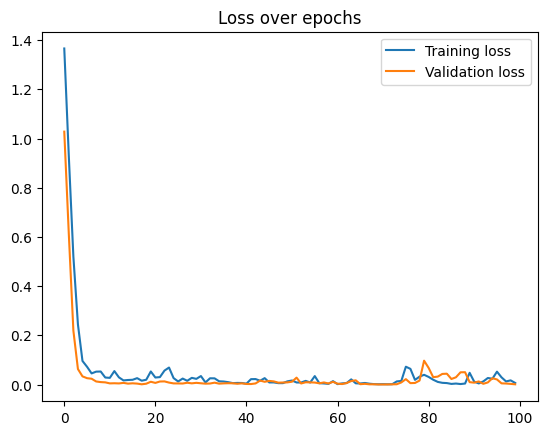

In [21]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

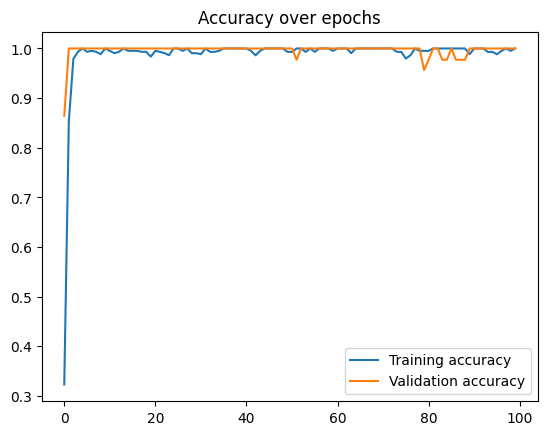

In [22]:
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

# Load MlFlow Registerd Model

model_name = "ResNet50_Freeze"
model_version = "1"
model = mlflow.pytorch.load_model(f"models:/{model_name}/{model_version}")

# Test Model with Seperated Test Data

In [23]:
#TEST_FOLDER_DIR = os.path.join(os.path.dirname(MAIN_DIR), "test_data")
TEST_FOLDER_DIR = os.path.join(MAIN_DIR, "test_data")
test_data, test_labels = [], []

for dir_ in os.listdir(TEST_FOLDER_DIR):
    path = os.path.join(TEST_FOLDER_DIR, dir_)

    for img in os.listdir(path):
        image_tensor = transformed_image(os.path.join(path, img))
        test_data.append(image_tensor)
        test_labels.append(dir_)


In [24]:
test_dataset = SignDataset(test_data, test_labels)
len(test_dataset)
test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset))

for data, label in test_dataloader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([35, 3, 224, 224])
torch.Size([35])


In [25]:
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        for image_batch, label_batch in tqdm(test_dataloader, desc = "Validation loop"):
            images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)
            outputs = model(images)
            return outputs, labels

In [26]:
predicted, ground_truth = predict(model, test_dataloader)

accuracy = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
precision = Precision(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
recall = Recall(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
f1score = F1Score(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)

accuracy.update(predicted, ground_truth)
precision.update(predicted, ground_truth)
recall.update(predicted, ground_truth)
f1score.update(predicted, ground_truth)

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
print(predicted)
print(ground_truth)

tensor([[ 3.4939e-01, -3.0795e+00, -1.9385e+00,  2.6014e+00],
        [-9.9821e-03, -1.2212e+00, -1.7587e+00,  1.0782e+00],
        [-2.1566e-01, -8.5354e-01, -1.3862e+00,  1.1518e+00],
        [ 2.6768e+00, -2.1906e+00, -2.4222e+00, -4.0465e-01],
        [ 4.1991e-01, -1.3272e+00, -3.5532e-01, -8.6083e-01],
        [ 1.2466e+00, -1.3723e+00, -3.3963e-03, -1.3621e+00],
        [-1.0849e+00, -3.5876e+00, -1.8404e+00,  3.9919e+00],
        [-1.2072e-01, -1.4847e+00, -9.8378e-01,  1.5085e+00],
        [ 8.7325e+00, -4.0630e+00, -4.5447e+00, -3.5727e+00],
        [-2.4351e+00,  5.0727e+00, -3.6223e+00, -1.5614e+00],
        [-2.1988e+00,  1.1341e+00, -6.0159e-01,  4.4715e-02],
        [-4.1639e+00,  8.2323e+00, -4.5868e+00, -2.2237e+00],
        [-2.8694e+00,  2.5514e+00, -1.0676e+00, -1.1182e+00],
        [-3.0826e+00,  5.9718e+00, -3.5024e+00, -1.6330e+00],
        [-2.8554e+00,  5.2098e+00, -2.8330e+00, -1.4564e+00],
        [-9.5821e-01,  1.3468e+00,  2.3826e-01, -2.0733e+00],
        

In [28]:
# Compute and print results
print("Accuracy:", accuracy.compute())
print("Precision:", precision.compute())
print("Recall:", recall.compute())
print("F1 Score:", f1score.compute())

Accuracy: tensor(0.7500, device='cuda:0')
Precision: tensor(0.8333, device='cuda:0')
Recall: tensor(0.7500, device='cuda:0')
F1 Score: tensor(0.7264, device='cuda:0')


# Logging with MlFlow

In [29]:
# Log parameters 
mlflow.log_param("optimizer", "Adam")
mlflow.log_param("learning_rate", 0.01)
mlflow.log_param("weight_decay", 0.0)
mlflow.log_param("loss_function", "CrossEntropyLoss")
mlflow.log_param("epoch", 100)
mlflow.log_param("traing_batch_size", 16)
mlflow.log_param("validation_batch_size", 16)

16

In [30]:
# Log result
mlflow.log_metric("train_loss", train_loss)
mlflow.log_metric("train_accuracy", train_acc)
mlflow.log_metric("validation_loss", val_loss)
mlflow.log_metric("validation_accuracy", val_acc)
mlflow.log_metric("test_accuracy", accuracy.compute())
mlflow.log_metric("test_precision", precision.compute())
mlflow.log_metric("test_recall", recall.compute())
mlflow.log_metric("test_f1", f1score.compute())

In [31]:
# Log dataset
mlflow.log_artifacts(DATA_DIR, artifact_path="dataset")
mlflow.log_artifacts(TEST_FOLDER_DIR, artifact_path="test_dataset")

In [32]:
# Log model
mlflow.pytorch.log_model(artifact_path="ResNet50_Unfreeze", pytorch_model=model, registered_model_name="ResNet50_Unfreeze")

2025/06/25 15:26:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/25 15:26:24 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.22.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.22.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/25 15:26:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'ResNet5